# LMS Exploration | 8. Portrait_Mode_CV
---
**[Introduce]**  
* 이미지 세그멘테이션(image segmentation) 기법을 활용하여 인물사진 모드(portrait mode)를 만들어보겠습니다.
* Segmentation model 중 DeepLab v3+ 알고리즘을 사용합니다.
* 인물사진 모드는 쉽게 말하면 피사체를 가깝게 찍을 때 배경이 흐려지는 효과입니다.
* 정확한 표현으로는 얕은 피사계 심도(shallow depth of field) 또는 셸로우 포커스(shallow focus)입니다.

* 이미지 세그멘테이션 기법을 활용해서 크로마키사진을 만들어보겠습니다
* 인물사진모드에서 발생한 문제점을 찾고, 보완할 수 있는 방법에 대해 연구해봅니다.


**[Data]**  
* 총 31 장의 다양한 사진을 사용하여 다양한 이미지 효과를 만들어봅시다.
* pretrained DeelLabModel에서 학습한 다양한 object 를 잘 추출해내는지 시험해보기 위해서   
  flower, dog, human, cat, car, bicycle, chair가 포함된 다양한 이미지를 준비했습니다. (*깃허브 용량 문제로 일부만 업로드*) 
* 크로마키합성을 위해서 다양한 배경사진도 포함했습니다~ (Photo by babeebird)
---

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf

# 0. Preparation
* Segmentation model 
* image

## DeepLabModel

* 구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드하고 DeepLabModel 을 초기화합니다.
* 이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전입니다.

In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'
    
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()
        
        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')
            
        self.sess = tf.compat.v1.Session(graph=self.graph)
        
    def preprocess(self, img_orig): #- 전처리
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0*self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
    
    def run(self, image): #- 세그맨테이션 실행
        img_input = self.preprocess(image)
        
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME : [img_input]})
        
        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map     

In [3]:
# define model and download & load pretrained weight

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


[urllib.request.urlretrieve](https://docs.python.org/3/library/urllib.request.html)(url, filename=None, reporthook=None, data=None)  
Copy a network object denoted by a URL to a local file.

In [4]:
#- DeepLab이 학습한 PASCAL VOC의 라벨

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [5]:
pascal_voc_dict = {v:k for (v,k) in enumerate(LABEL_NAMES)}
pascal_voc_dict

{0: 'background',
 1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tv'}

* DeepLab이 학습한 PASCAL VOC에는 background를 제외하면 총 20개의 클래스가 있습니다.
* 꽤나 다양한 Object가 포함되어 있습니다. 얼마나 Object를 잘 검출해낼지 기대되네요~ 
* 이후에 사용하기 위해 Pascal Voc의 label index 와 label name 이 매칭된 사전pascal_voc_dict를 생성합니다.


* (잊지말기로해~) cv2는 이미지를 HWC(Height, Width, Channel) 순서로 표시합니다.

## 이미지 불러오기 

In [6]:
from itertools import zip_longest 
import pandas as pd

파일 이름을 통일했으면, 코드로 분류할 수 있었을 법 한데..   
손수 한땀한땀 분류해넣은 이미지 list 입니다.

In [7]:
flower_list=['granma_flower.jpg','potted_congo.jpg', 'avocado.jpg' ]
dog_list = ['doggy.jpg', 'fishing_doggy.jpg']
bird_list = ['ravens.jpg', 'birddy.jpg', 'fancy_bird.jpg' ]
human_list = ['i_luv_cake.png', 'mountain_girl.png', 'cat_friends.png', 'flower_friends.png', 'station.png', 'bicycle.png']
cat_list = ['pretty_cat.jpg','lying_cat.png']
bg_list = ['pond.jpg', 'boramae_park.jpg', 'sea.jpg', 'tree.jpg', 'mountain.jpg','mid_sea.jpg', 'going_ikea.jpg', 'moon.jpg', 'lake.jpg', 'fly_to_the_sky.jpg', 'greenary.jpg', 'street.jpg', 'sky.png']
chair_list = ['drying.jpg']
bicycle_list = ['bicycle.png', 'bicycle_family.jpg']

Pandas로 불러온 사진 목록을 확인하고,

In [8]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images'
file_list = os.listdir(img_path)
file_list_show = pd.DataFrame(data = zip_longest(bg_list,flower_list, dog_list,cat_list, bird_list, human_list,chair_list,bicycle_list, fillvalue='♬'), columns=['background','flower','dog','cat','bird','human','chair','bicycle'])
file_list_show

background             flower                dog             cat  \
0             pond.jpg  granma_flower.jpg          doggy.jpg  pretty_cat.jpg   
1     boramae_park.jpg   potted_congo.jpg  fishing_doggy.jpg   lying_cat.png   
2              sea.jpg        avocado.jpg                  ♬               ♬   
3             tree.jpg                  ♬                  ♬               ♬   
4         mountain.jpg                  ♬                  ♬               ♬   
5          mid_sea.jpg                  ♬                  ♬               ♬   
6       going_ikea.jpg                  ♬                  ♬               ♬   
7             moon.jpg                  ♬                  ♬               ♬   
8             lake.jpg                  ♬                  ♬               ♬   
9   fly_to_the_sky.jpg                  ♬                  ♬               ♬   
10        greenary.jpg                  ♬                  ♬               ♬   
11          street.jpg                  ♬                  ♬               ♬   
12             sky.png                  ♬                  ♬               ♬   

              bird               human       chair             bicycle  
0       ravens.jpg      i_luv_cake.png  drying.jpg         bicycle.png  
1       birddy.jpg   mountain_girl.png           ♬  bicycle_family.jpg  
2   fancy_bird.jpg     cat_friends.png           ♬                   ♬  
3                ♬  flower_friends.png           ♬                   ♬  
4                ♬         station.png           ♬                   ♬  
5                ♬         bicycle.png           ♬                   ♬  
6                ♬                   ♬           ♬                   ♬  
7                ♬                   ♬           ♬                   ♬  
8                ♬                   ♬           ♬                   ♬  
9                ♬                   ♬           ♬                   ♬  
10               ♬                   ♬           ♬                   ♬  
11               ♬                   ♬           ♬                   ♬  
12               ♬                   ♬           ♬                   ♬

matplot으로 어떤 사진이 있는지 확인해봅니다!!


하나하나 저의 추억이 깃들어 있는 풍경이네요 :-D


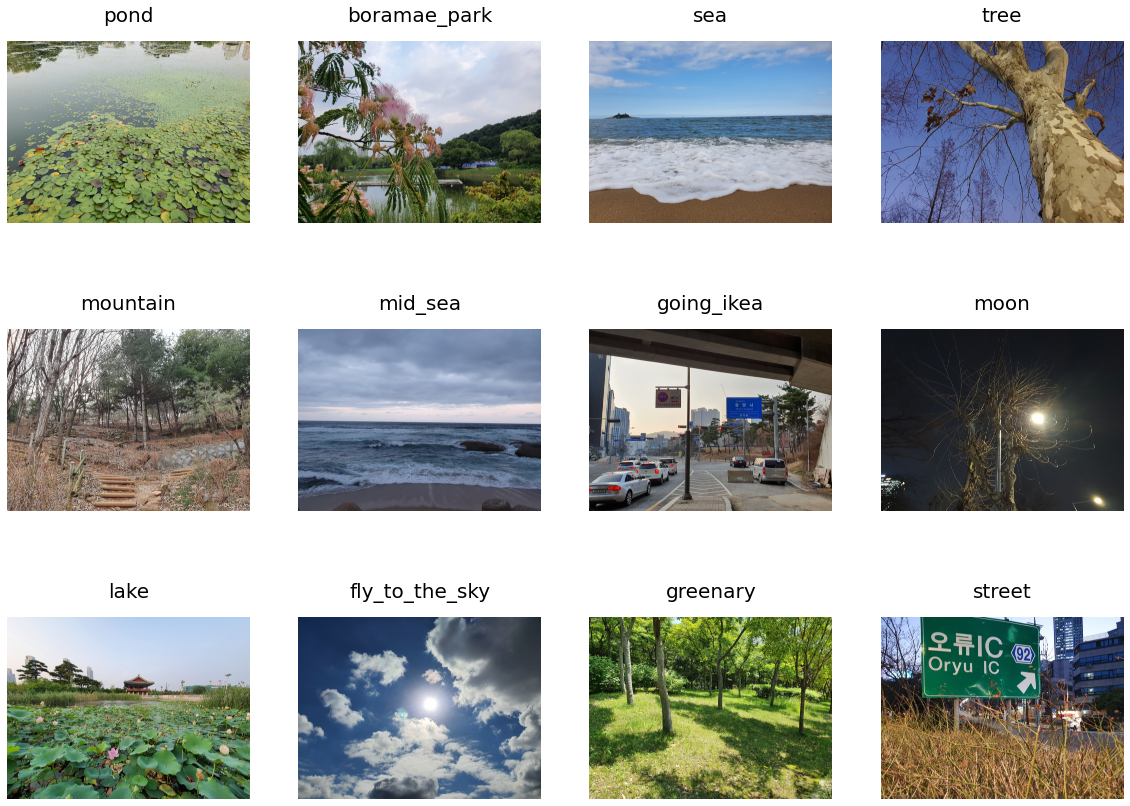

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20,15))

for i, ax in enumerate(axes.flatten()): #- 파일 이미지 확인하기
    file_path = os.path.join(img_path, bg_list[i])
    img= cv2.imread(file_path)
    bg_name = bg_list[i].split('.')[0]
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title(bg_name, fontsize=20, pad=20 )


plt.show()
fig.tight_layout()

# 1. function declaration | 함수 선언

## 1-1. 인물사진모드
* 인물사진모드 함수 select_object_blurring

#### Sementic Segmentation
Sementic Segmentation 이란 단순히 사진을 보고 분류하는 것에 그치지 않고, 그 장면을 이해해야 하는 수준의 문제로, 사진에 있는 모든 픽셀을 해당하는 class로 분류하는 것이 목적입니다. 이미지에 있는 모든 픽셀에 대한 예측을 하는 것이기에 dense prediction이라 불리기도 합니다.


#### 세그멘테이션 이미지 Normalization
예측된 세그멘테이션 이미지(map)는 0~20의 값으로 구성된 배열로 표현됩니다.
일반 이미지는 0부터 255까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하게 위해 255로 정규화하겠습니다.  applyColorMap() 함수로 색을 적용하고 이미지를 화면에 출력하면 세그멘테이션 결과를 확인할 수 있습니다.

#### 세그멘테이션 결과(mask)를 원래 크기로 복원
크기를 키울 때에는 보간(interpolation) 을 고려해야 합니다. cv2.INTER_NEAREST를 이용할 수도 있지만, 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용하겠습니다.
결과적으로 img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻습니다. 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정합니다. 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법입니다.

In [10]:
def select_object_blurring(filename:str, label:int, blur_kernel:int):
    
    '''
    [Parameter]
    
    * filename은 확장자를 포함한 str으로 표기하세요.
    * label은 segmentation 영역을 추출할 object의 PASCAL VOC 라벨을 의미합니다.
         None으로 설정시 이미지에서 segmentation 된 모든 object가 추출됩니다.
    * blur_kernal은 blurring kernel size를 의미합니다.
    '''
    
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images'
    file_path = os.path.join(img_path, filename)
    img_orig= cv2.imread(file_path)
    img_resized, seg_map = MODEL.run(img_orig)
    seg_map_label = [i for i in np.unique(seg_map) if i > 0 ] #- 추출한 object label 리스트
    seg_map_object = list(map(pascal_voc_dict.get, seg_map_label)) #- 추출한 object label name 리스트 
    
    img_show = img_resized.copy()
    if label != None: #- 특정 object 선택한 경우
        seg_map = np.where(seg_map == label, label, 0 )
        img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    seg_map = np.where(seg_map != 0, 255 ,0 ) 
    img_mask = seg_map
    img_mask = img_mask.astype(np.uint8)
    
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
    img_orig_blur = cv2.blur(img_orig, (blur_kernel,blur_kernel))  
    
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    
    plt.figure(figsize=(20,10))

    ax = plt.subplot(1,4,1) #- 원본 이미지
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.title('Original image',fontsize=15, pad=10)

    ax = plt.subplot(1,4,2) #- Seg_map 이미지
    plt.axis('off')
    plt.imshow(seg_map)
    plt.title(f'object segmentation : {seg_map_object}',fontsize=15, pad=10, loc='center')
    
    ax = plt.subplot(1,4,3) #- 전체 블러 이미지
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.title('All Blur image',fontsize=15, pad=10)

    ax = plt.subplot(1,4,4) #- 인물모드(부분블러) 이미지
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.title('Selected Blur image',fontsize=15, pad=10)
    
    
    plt.show()

## 1-2. 크로마키합성
* 크로마키합성 함수 select_object_blending

In [11]:
def select_object_blending(filename:str, bg_filename:str, label, axis_show:bool=False):
    '''
    [Parameter]
    * filename에는 object를 추출할 이미지파일의 이름을 확장자를 포함한 str으로 표기하세요
    * bg_filename에는 이미지 합성 시 배경이 될 이미지 파일의 이름을 확장자를 포함하여 표기합니다.
    *label은 segmentation 영역을 추출할 object의 PASCAL VOC 라벨을 의미합니다.
         None으로 설정시 이미지에서 segmentation 된 모든 object가 추출됩니다.
    *axis는 좌표축 on/off 선택 인자로, axis=True 일 경우 on입니다. 
         
    '''
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images'
    file_path = os.path.join(img_path, filename)
    file_name = filename.split('.')[0]
    
    img_orig= cv2.imread(file_path) #- 추출이미지 읽어오기
    
    img_resized, seg_map = MODEL.run(img_orig)
    seg_map_label = [i for i in np.unique(seg_map) if i > 0 ] #- 추출한 object label 리스트
    seg_map_object = list(map(pascal_voc_dict.get, seg_map_label)) #- 추출한 object label name 리스트 
    
    file_path = os.path.join(img_path, bg_filename)
    img_bg= cv2.imread(file_path) #- 배경이미지 읽어오기
    height, width = img_bg.shape[0],img_bg.shape[1] #- cv 이미지 shape은 (H,W,C)
    
    img_orig=cv2.resize(img_orig, (width, height),interpolation=cv2.INTER_LINEAR)
    
    img_show = img_resized.copy()
    
    if label != None: #- 특정 object 선택한 경우
        seg_map = np.where(seg_map == label, label, 0 )
        img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    seg_map = np.where(seg_map != 0, 255 ,0 )
    img_mask = seg_map
    img_mask = img_mask.astype(np.uint8)
      
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    img_mask_up = cv2.resize(img_mask, (width, height), interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    
    img_concat = np.where(img_mask_color==255, img_orig, img_bg)
    if axis_show == False:
        plt.figure(figsize=(12,6))
        
        ax = plt.subplot(1,2,1)
        plt.axis('off')
        plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
        plt.title(file_name,fontsize=15, pad=10)
        
        ax = plt.subplot(1,2,2)
        plt.axis('off')
        plt.imshow(seg_map)
        plt.title(f'object segmentation : {seg_map_object}',fontsize=15, pad=10, loc='center')
    
        plt.show()
        
        return img_concat
    
    
    return img_concat, seg_map, file_name, seg_map_object

# 3. Application | 적용하기

## 3-1. Shallow Focus

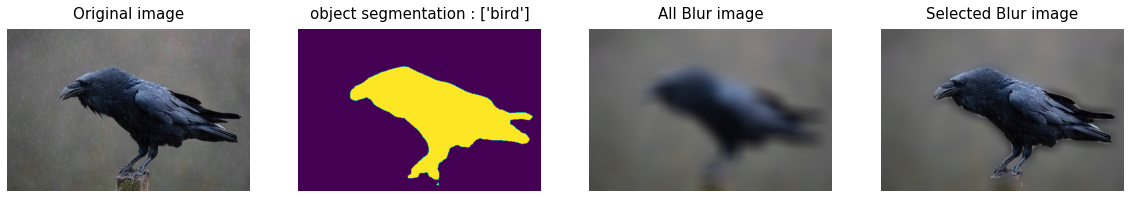

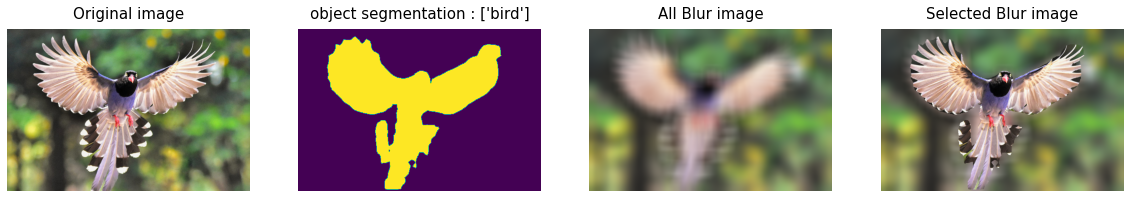

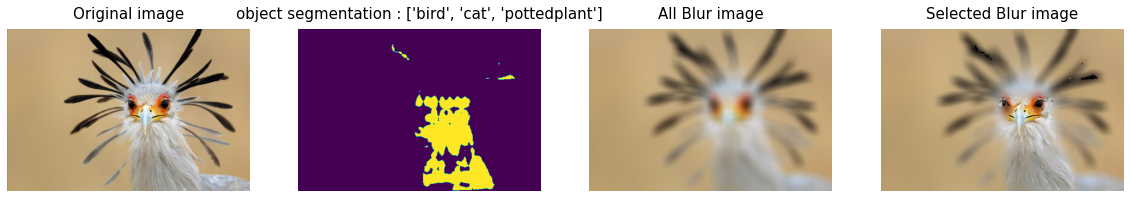

In [12]:
#- 새의 세밀한 깃털은 잘 인식하지 못한다.

for file in bird_list:
    blur_img = select_object_blurring(file, 3 ,50) 

```python
#- 인물의 실루엣은 잘 인식하지만 세밀한 경계선은 정확하지 않다. 

for file in human_list:
    blur_img = select_object_blurring(file, 15 ,50)
```

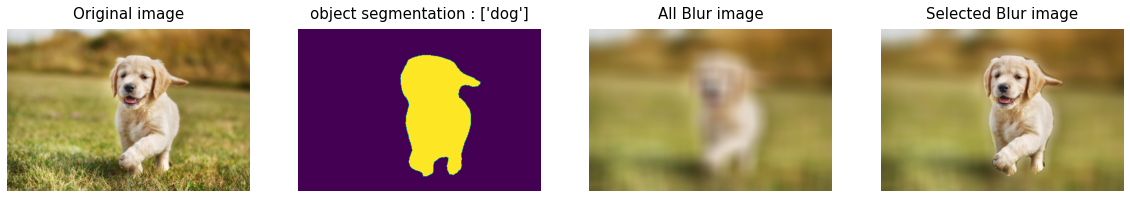

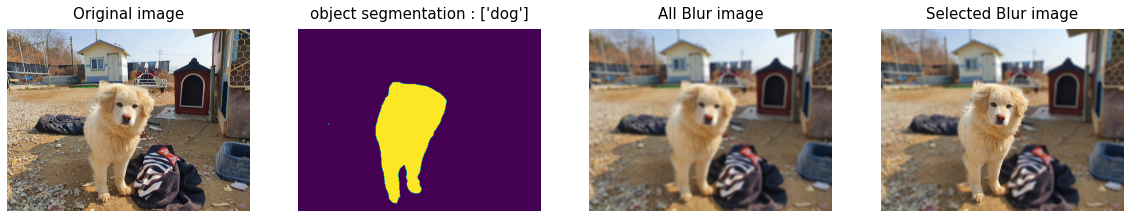

In [13]:
#- 댕댕이를 아주 깔끔하게 잘 인식했다.

for file in dog_list:
    blur_img = select_object_blurring(file, 12 ,50)

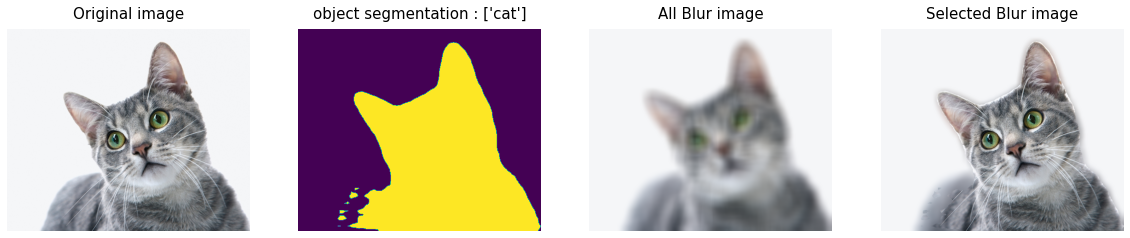

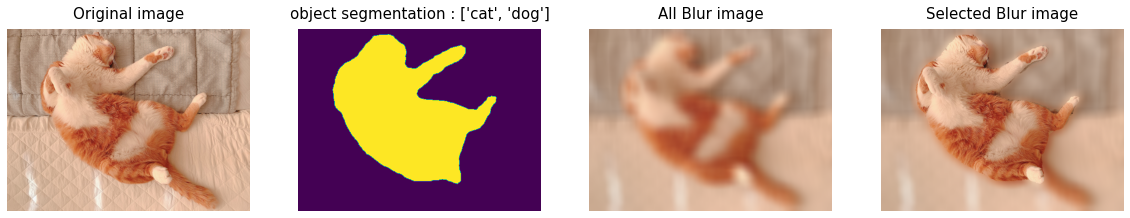

In [14]:
#- 발라당 고양이의 꼬리를 인식하지 못한다.

for file in cat_list:
    blur_img = select_object_blurring(file, 8 ,30)

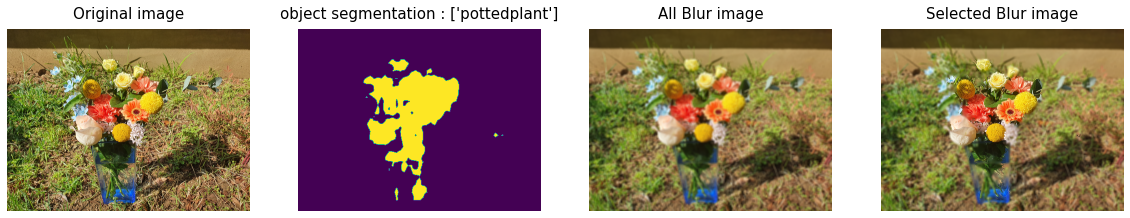

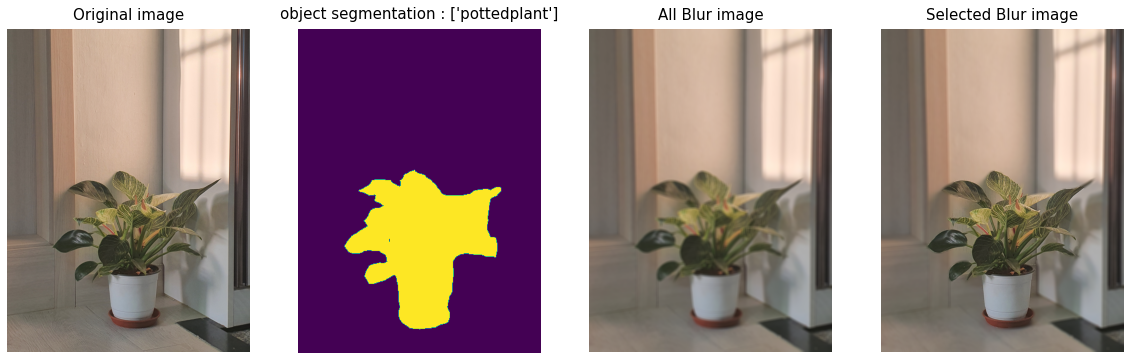

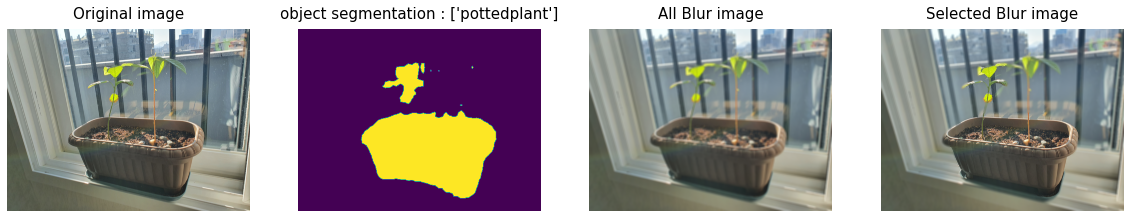

In [15]:
#- 꽃잎, 줄기 등 세밀한 부분을 인식하지 못한다. 

for file in flower_list:
    blur_img = select_object_blurring(file, 16 ,40)

## 3-2.Chroma Key (두둥~!)
크로마키 합성은 재밌다 !!!!!  

맘같아서는 자르고 돌리고 색칠하고 하고싶은게 많지만..     
초짜가 하기엔 시간도둑이라 pass.. 

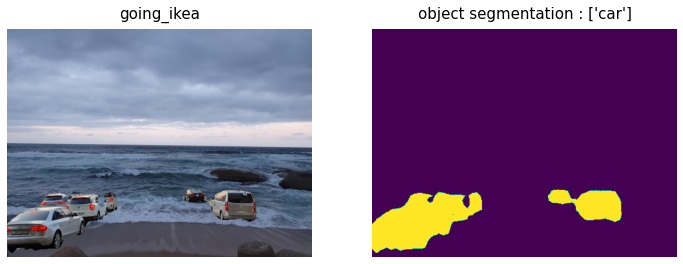

In [16]:
blend_img = select_object_blending('going_ikea.jpg', 'mid_sea.jpg', 7)

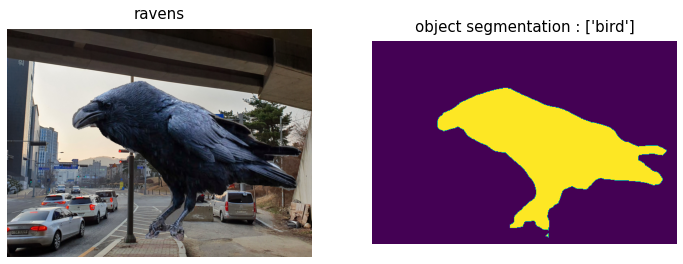

In [17]:
blend_img = select_object_blending('ravens.jpg', 'going_ikea.jpg', 3)

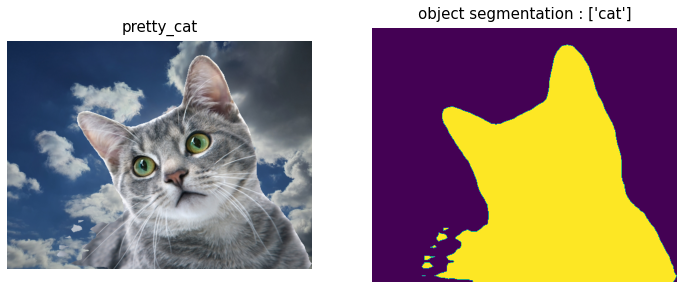

In [18]:
blend_img = select_object_blending('pretty_cat.jpg', 'fly_to_the_sky.jpg', 8)

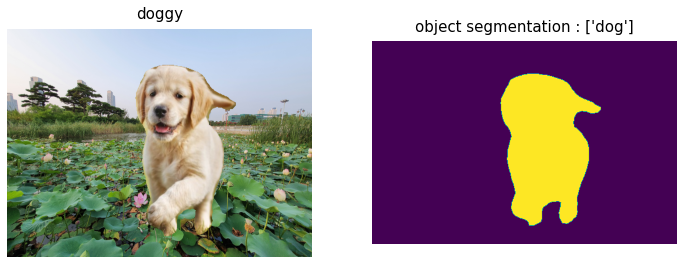

In [19]:
blend_img = select_object_blending('doggy.jpg', 'lake.jpg', 12)

# 4. 인물모드 문제점 탐색하기
인물모드의 문제점을 matplot의 annotate 기능으로 정확히 표시하고 분석해보겠습니다

In [20]:
def annotate_show(blend_img, seg_map, file_name, seg_map_object, xy=(0,0), xytext=(0,0)):
    plt.figure(figsize=(12,6))
    ax = plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
    plt.annotate('',xy, xytext, arrowprops=dict(facecolor='yellow'))
    plt.title(file_name,fontsize=15, pad=10)

    ax = plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(seg_map)
    plt.title(f'object segmentation : {seg_map_object}',fontsize=15, pad=10, loc='center')

    plt.show()

## 4-1. 불분명한 경계선
눈코입, 손가락과 같은 세밀한 경계선을 잘 잡아내지 못한다. 전체적인 실루엣은 잘 잡아내는 편이지만, 다리사이 또는 팔안쪽과 같은 인물사진 내부의 배경 경계선을 잘 인식하지 못한다.  

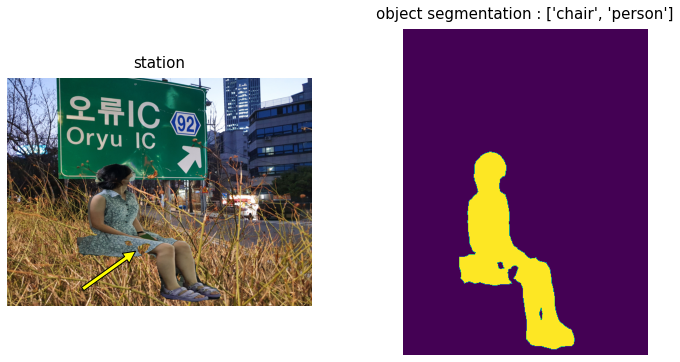

In [21]:
#- 옷 masking 미흡

blend_img, seg_map, file_name, seg_map_object = select_object_blending('station.png', 'street.jpg',15,True)
annotate_show(blend_img, seg_map, file_name, seg_map_object, xy=(1700,2300), xytext=(1000,2800))

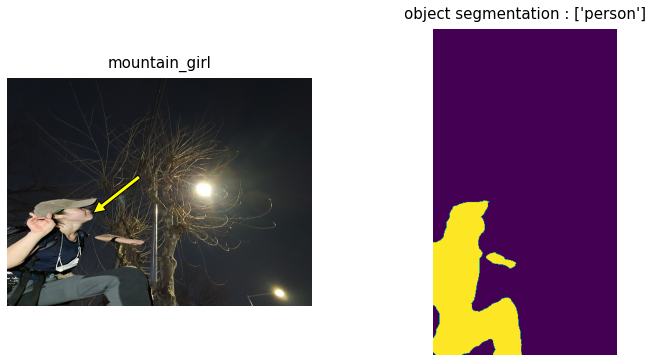

In [22]:
#- 코, 입 뭉개짐

blend_img, seg_map, file_name, seg_map_object = select_object_blending('mountain_girl.png', 'moon.jpg',15,True)
annotate_show(blend_img, seg_map, file_name, seg_map_object, xy=(1300,2050), xytext=(2000,1500))

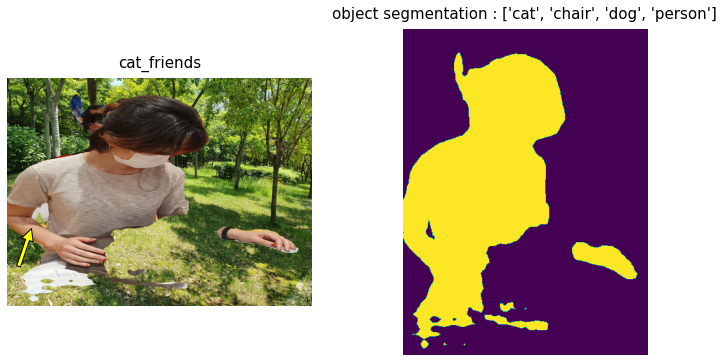

In [23]:
#- 팔 안쪽, 머리 위

blend_img, seg_map, file_name, seg_map_object = select_object_blending('cat_friends.png', 'greenary.jpg',15,True)
annotate_show(blend_img, seg_map, file_name, seg_map_object, xy=(320,2000), xytext=(150,2500))

```python
#- 각 물체의 object detection은 잘 이뤄졌지만, 차와 자전거의 경우 경계선이 굉장히 거친 것을 확인할 수 있다.

blend_img = select_object_blending('bicycle.png', 'sea.jpg', 7) #- car
blend_img = select_object_blending('bicycle.png', 'sea.jpg', 15) #- person
blend_img = select_object_blending('bicycle.png', 'sea.jpg', 2) #- bicycle
```

## 4-2. 인식의 한계 
크고 뚜렷한 물체는 비교적 잘 추출해내지만,
작거나 특징이 뚜렷하지 않은 경우 제대로 물체를 인식하지 못하는 경우가 발생한다.

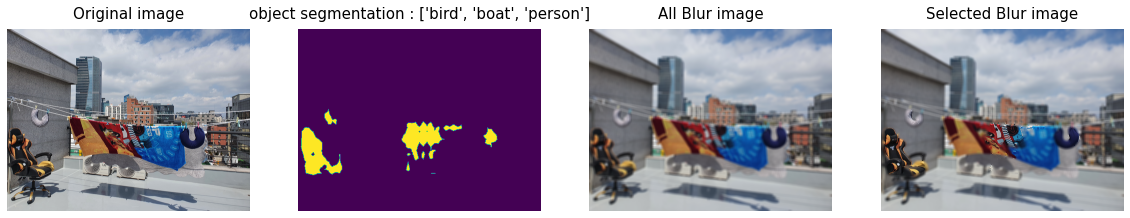

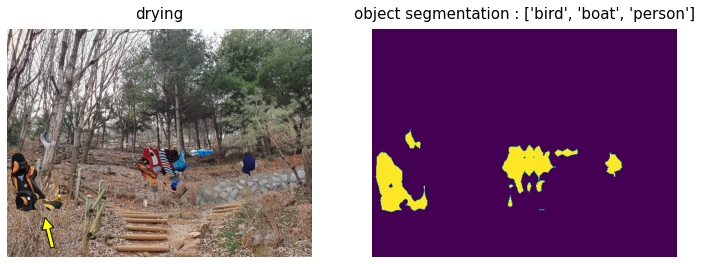

In [24]:
#- 의자를 인식하지 못함. 새, 보트, 인간이 추출됨.

blur_img = select_object_blurring('drying.jpg', None ,50) 
blend_img, seg_map, file_name, seg_map_object = select_object_blending('drying.jpg', 'mountain.jpg', None,True)
annotate_show(blend_img, seg_map, file_name, seg_map_object, xy=(500,2500), xytext=(600,2900))

# 5. 문제점 해결방안 연구

Object가 크고 뚜렷한 경우엔 Image Segmentation이 잘 이루어졌습니다. 하지만 섬세한 깃털을 가진 새, 꽃 잎, 사람의 손가락과 이목구비, 자전거 바퀴와 같이 복잡하고 세밀한 부분의 경계는 잘 인식하지 못했습니다. 

이는 심도 정보가 없는 Image Segmentation의 한계라고 생각됩니다. 
따라서 아래와 같은 해결방안을 제안할 수 있습니다.

---



#### Segmentation 모델

* 좀 더 성능이 향상된 Image Segmentation 모델을 사용하는 방법입니다. 
* 우리가 Image Segmentation에 사용한 DeepLab v3+는 2018년 Semantic Segmentation on PASCAL VOC 2012 test의 Best Model이었습니다. Xception model을 채택하고, depthwise separable convolution을 atrous spatial pyramid pooling(ASPP module)과 decoder에 적용했습니다. 

* **HRNet-OCR** (Hierarchical Multi-Scale Attention for Semantic Segmentation) 는 2020년  Semantic Segmentation on Cityscapes test의 Best Model입니다.성능향상을 위해 multi-scale inference를 사용합니다. 여러 스케일의 이미지가 네트워크를 통과하고 그 결과가 averaging 또는 max pooling 연산을 통해 결합됩니다. 

* **EfficientNet-L2+NAS-FPN**은 2020년 Semantic Segmentation on PASCAL VOC 2012 test의 Best Model 입니다. BiFPN과 Model Scaling을 적용해서 COCO 데이터셋에서 가장 높은 정확도를 달성했고, 기존 연구들에 비해 매우 적은 연산량(FLOPS)으로 비슷한 정확도를 달성했습니다.

#### 피사계 심도
* 피사계심도(depth of field, DOF)는 한 사진의 초점이 맞은 것으로 인식되는 범위를 일컫습니다. 

* 피사계심도를 이용한 보케(아웃포커싱) 효과는 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 섬세하게 구별하지만 semantic segmentation 모듈은 한계가 있습니다. 
* 컴퓨터 비전에서 깊이 추정은 장면에서 기하학적 관계를 보여주는 대표적인 문제입니다. 
* Depth Estimation 연구는 2D 이미지로부터 3D 복원을 수행하기 위해 합성곱 신경망 (CNN) 활용에 중점을 두고 있습니다.
* 다음 논문에서는 합성곱 신경망을 이용하여 DoF 영역을 추출할 수 있는 새로운 네트워크 모델을 제안합니다.  
[Artificial Neural Network Method Based on Convolution to Efficiently Extract the DoF Embodied in Images](https://www.koreascience.or.kr/article/JAKO202110463369854.pdf)

    * 피사계 심도 영역을 효율적인 합성곱 신경망을 통해 찾는 방법입니다. RGB 채널기반의 상호-상관 필터를 이용하여 DoF영역을 이미지로부터 효율적으로 분류하고, 합성곱 신경망 네트워크에 학습하기 위한 데이터를 구축하며, 이렇게 얻어진 데이터를 이용하여 이미지-DoF가중치 맵 데이터 쌍을 설정합니다. 학습할 때 사용되는 데이터는 이미지와 상호-상관필터 기반으로 추출된 DoF 가중치 맵을 이용하며, 네트워크 학습 단계에서 수렴률을 높이기 위해 스무딩을 과정을 한번 더 적용한 결과를 사용합니다. 테스트 결과로 얻은 DoF 가중치 이미지는 입력 이미지에서 DoF영역을 안정적으로 찾아낼 수 있습니다.

 

#### 3D Depth Camera 활용하기
* 스마트폰에 카메라 렌즈가 많아진 이유는 스마트폰으로도 DSLR 처럼 다양한 효과가 적용된 사진을 찍을 수 있기 때문입니다. 
* 과거에는 스마트폰으로 배경을 흐리게 하는 보케효과를 준 사진을 찍기 어려웠지만, 듀얼 카메라로 촬영한 사진의 심도를 측정해 보케효과를 적용할 수 있게 됐습니다.  
* 3D Depth camera란 Computational Camera의 한 종류로 기존의 2D에서 할 수 없었던 이미지 각 픽셀의 깊이 값을 계산할 수 있는 기술입니다. 기존의 1개 카메라 모듈만으로 처리했던 2D 방식과 달리 카메라 모듈 2대를 사용하여 픽셀의 깊이를 계산하여 3D 이미지를 나타냅니다. 
* 전통적 카메라는 피사체를 렌즈를 통해 투과시켜 카메라 암상자에서 이미지를 얻는 방식이었다면, Computational Camera는 피사체들로부터 렌즈를 통해 들어오는 이미지에 연산을 통해서 이미지를 재가공하여 이미지를 만들어 내는 카메라 입니다. 

# 6. 자기평가

시간과 노력 대비 결과는 작고 귀엽게 느껴지지만,
크로마키합성 과정이 재밌었다. 

Image Segmentation의 문제점과 해결방안에 대해서 고민하다보니,
실제로 해결해보고 싶어진다. 
우선은 성능이 향상된 모델들의 능력치가 궁금하다. 
3D Depth Camera의 능력치는 스마트폰의 카메라를 키면 쉽게 알 수 있다. 인물사진모드로 촬영한 이미지의 심도를 조절할 수도 있고 라이브포커싱사진을 만들 수 있으며 요즘엔 전면에도 심도카메라가 부착되어있어서 셀피를 찍을 때도 아웃포커싱이 가능하다. 

창의적인 문제 해결방법이 잘 떠오르지 않는데, 다른 분들의 신선한 아이디어가 궁금하다. 

합성곱신경망을 이용한 피사계심도 영역추출에 대한 따끈따끈(?)한 논문을 소화하지는 못했지만, 
인공지능이라는 분야가 계속해서 연구되고 발전중인 분야라는 것을 느낄 수 있었다. 